In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const
import data.scripts.gen_tables.gen_pair_configs as gen_pair

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 

In [3]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Seq

In [7]:
# run python scripts to generate all the pickles needed
gen_seq = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_seq.py')   
%run $gen_seq 

df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq.pkl'))
print(df_seq.columns)

Index(['pair_str', 'config', 'gpusim_version', 'jobId', 'grid_x', 'grid_y',
       'grid_z', 'block_x', 'block_y', 'block_z', 'ctas/SM', 'runtime', 'ipc',
       'instructions', 'avg_mem_lat', 'avg_core_to_l2', 'avg_l2_to_core',
       'avg_mrq_latency', 'stall_core_ldst', 'stall_icnt_to_l2', 'l2_BW',
       'l2_rshr_entry_fail', 'l2_rshr_merge_fail', 'stall_l2_to_icnt',
       'l1D_miss_rate', 'l2_miss_rate', 'l2_total_accesses', 'packet_lat_out',
       'network_lat_out', 'inject_out', 'accepted_out', 'packet_lat_in',
       'network_lat_in', 'inject_in', 'accepted_in',
       'mem_subpartition_parallism', 'mem_subpartition_parallism_util',
       'L2_reservation_fail', 'empty_warp', 'stall_warp', 'idle_warp',
       'scoreboard_warp', 'tot_warp_insn', 'regs', 'smem', 'mem_count',
       'sp_winsn', 'dp_winsn', 'int_winsn', 'tensor_winsn', 'sfu_winsn',
       'mem_insn', 'sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy',
       'barrier_cycles', 'inst_empty_cycles', 'branch

In [19]:
col_seq = ['pair_str', 'runtime', 'instructions', 'ipc', 'avg_dram_bw', 
           'avg_dram_eff', 'avg_mem_lat', 'MPKI', 'waves',
           'sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy',
#            'barrier_cycles', 'inst_empty_cycles', 'branch_cycles', 'scoreboard_cycles', 
#            'stall_sp_cycles', 'stall_dp_cycles', 'stall_int_cycles', 'stall_tensor_cycles', 'stall_sfu_cycles', 
#            'stall_mem_cycles', 'not_selected_cycles',
           'avg_row_locality',
#            'l2_total_accesses', 'l2_access_density',
          ]
df_seq.sort_values('pair_str', inplace=True)
df_seq.reset_index(inplace=True, drop=True)
draw_table(df_seq, col_seq, False).format(
    {'avg_dram_bw':'{:.4f}', 
     'ratio_dram_bw': '{:.2f}',
     'MPKI': '{:.2f}',
     'waves': '{:.2f}',
     'l2_total_accesses': '{:,}',
     'l2_access_density': '{:.1f}',
     'instructions': '{:,}',
     'runtime': '{:,}',
    })

,pair_str,runtime,instructions,ipc,avg_dram_bw,avg_dram_eff,avg_mem_lat,MPKI,waves,sp_busy,dp_busy,int_busy,tensor_busy,sfu_busy,avg_row_locality
0,cut_sgemm-1,"1,717,712","6,580,076,544",3830.72,0.0743,0.441912,885,0.34,3.20,0.244664,0,0.102328,0,0,0.35576
1,cut_wmma-0,"54,310","36,372,480",669.695,0.0190,0.116883,321,2.28,0.40,0.000957,0,0.051407,0.237561,0,0.769437
2,nvd_binomial-0,"1,589,162","6,133,492,736",3859.57,0.0000,0.168892,204,0.00,0.80,0.331151,0,0.034262,0,0.000916,0.687674
3,nvd_blackscholes-0,"184,821","292,000,000",1579.89,0.7694,0.826854,3271,8.56,12.21,0.097221,0,0.021135,0,0.105675,0.114878
4,nvd_fdtd3d-0,"2,227,894","3,172,739,184",1424.1,0.4299,0.451329,317,5.58,3.60,0.060757,0,0.025581,0,0,0.144283
5,nvd_interval-0,"69,288","97,138,283",1401.91,0.0188,0.235838,266,2.12,1.07,0,0.260294,0.030049,0,0.267986,0.609981
6,nvd_sobol-0,"153,289","690,560,000",4504.9,0.4232,0.594596,240,1.81,20.00,0.012741,0,0.359021,0,0,0.468483
7,parb_cutcp-0,"630,435","469,895,962",745.35,0.0000,0.100212,154,0.02,0.09,0.045514,0,0.013987,0,0.022933,0.778935
8,parb_lbm-0,"804,405","427,778,603",531.794,0.7738,0.781462,17415,26.30,18.75,0.041393,0,0.005763,0,0.0023,0.0886904
9,parb_spmv-0,"74,732","52,720,795",705.446,0.7600,0.840242,809,18.54,0.90,0.004753,0,0.04186,0,0,0.169547


# Intra

In [23]:
gen_intra = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_intra.py')
%run $gen_intra

In [24]:
df_intra = pd.read_pickle(os.path.join(PKL_PATH, 'intra.pkl'))
print(df_intra.shape)
col_intra = ['pair_str', 'intra', 'norm_ipc']

# draw_table(df_intra, col_intra)

(122, 97)


In [25]:
df_intra_best = pd.read_pickle(os.path.join(PKL_PATH, 'intra_best.pkl'))
df_intra_best.sort_values('pair_str', inplace=True)
col_intra_best = ['pair_str', 
        'perfdollar', 'intra', 'norm_ipc', 
        'runtime',
        #'l2_miss_rate',
        #'avg_mem_lat', 'avg_core_to_l2', 'avg_l2_to_core',
        'comp_busy', 'dram_busy', 'avg_dram_bw', 'avg_dram_eff']

draw_table(df_intra_best, col_intra_best).format({'norm_ipc': "{:.4f}", 'dominant_resc': '{:.2f}'})

pair_str,perfdollar,intra,norm_ipc,runtime,comp_busy,dram_busy,avg_dram_bw,avg_dram_eff
cut_sgemm-1,2.04596,1,0.9799,1752896,0.404858,0.208573,0.0998096,0.406346
cut_wmma-0,3.21183,2,1.0000,54310,0.0691257,0.084672,0.0189963,0.116883
nvd_binomial-0,2.84843,4,0.8341,1905150,0.389585,9.47586e-05,2.61808e-05,0.120794
nvd_blackscholes-0,0.977109,4,1.0290,179617,0.160902,0.952788,0.796804,0.833808
nvd_fdtd3d-0,0.730654,1,1.0000,2227894,0.181614,0.938097,0.429892,0.451329
nvd_interval-0,6.02727,4,0.8986,77103,0.14204,0.00387478,0.00124956,0.195292
nvd_sobol-0,1.17199,8,0.9455,162127,0.436481,0.677367,0.400146,0.522292
parb_cutcp-0,19.6898,2,1.0000,630435,0.106824,7.04461e-05,1.84737e-05,0.100212
parb_lbm-0,0.938811,1,0.9381,857512,0.0572212,0.993056,0.7293,0.7341
parb_spmv-0,0.923312,5,0.9842,75928,0.0723959,0.923502,0.752233,0.80335


In [18]:
df_bi = df_intra[df_intra['pair_str'] == 'nvd_binomial-0'].sort_values('intra')

draw_table(df_bi, col_intra)

pair_str,intra,norm_ipc
nvd_binomial-0,1,0.315063
nvd_binomial-0,2,0.554049
nvd_binomial-0,3,0.741616
nvd_binomial-0,4,0.83414
nvd_binomial-0,5,0.957136
nvd_binomial-0,6,0.893457
nvd_binomial-0,7,0.988477
nvd_binomial-0,8,1.00664
nvd_binomial-0,9,1.00525
nvd_binomial-0,10,0.983846


# Algorithm: Find pair configs

In [11]:
col_prod = ['norm_ipc_x', 'norm_ipc_y', 'diff_mflat', 'sum_ipc', 
            'intra_x', 'intra_y', 
           'sum_comp', 'sum_dram', 'penalized']
find_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_pair_configs.py')


app1 = widgets.Dropdown(
    options=df_seq['pair_str'],
    value='cut_sgemm-1',
    rows=5,
    description='App 1:',
    disabled=False
)

app2 = widgets.Dropdown(
    options=df_seq['pair_str'],
    value='cut_sgemm-1',
    rows=5,
    description='App 2:',
    disabled=False
)

qos = widgets.FloatSlider(
    value=0.75,
    min=0.1,
    max=0.95,
    step=0.05,
    description='QoS:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

button = widgets.Button(description='Calculate', button_style='info')

def show_widgets():
    display(app1)
    display(app2)
    display(qos)
    display(button)
    
show_widgets()

def onclick(b):
    clear_output()
    show_widgets()
    %run $find_pair --app $app1.value $app2.value --qos $qos.value
    
    df_prod = pd.read_pickle(os.path.join(PKL_PATH, 'pair_candidates.pkl'))
    print(df_prod.columns)
#     sns.lineplot('diff_mflat', 'sum_ipc', data=df_prod)
   
    display(HTML(draw_table(df_prod, col_prod, False).render()))
    
    
button.on_click(onclick)

Dropdown(description='App 1:', index=2, options=('cut_sgemm-1', 'cut_wmma-0', 'nvd_binomial-0', 'nvd_blackscho…

Dropdown(description='App 2:', index=7, options=('cut_sgemm-1', 'cut_wmma-0', 'nvd_binomial-0', 'nvd_blackscho…

FloatSlider(value=0.75, continuous_update=False, description='QoS:', max=0.95, min=0.1, step=0.05)

Button(button_style='info', description='Calculate', style=ButtonStyle())

Index(['index', 'pair_str_x', 'config_x', 'gpusim_version_x', 'jobId_x',
       'grid_x_x', 'grid_y_x', 'grid_z_x', 'block_x_x', 'block_y_x',
       ...
       'thread_ratio_y', 'smem_ratio_y', 'reg_ratio_y', 'usage_y',
       'diff_mflat', 'sum_ipc', 'sum_comp', 'sum_dram', 'penalized', 'config'],
      dtype='object', length=198)


,norm_ipc_x,norm_ipc_y,diff_mflat,sum_ipc,intra_x,intra_y,sum_comp,sum_dram,penalized
0,0.83414,1,42,1.83414,4,2,0.496409,0.000165205,parb_cutcp-0
1,0.83414,0.763717,46,1.59786,4,1,0.471111,0.000148631,parb_cutcp-0
2,0.9403,1,49,1.9403,11,2,0.532108,0.00016912,parb_cutcp-0
3,0.893457,1,50,1.89346,6,2,0.521641,0.000173034,parb_cutcp-0
4,1.00525,1,50,2.00525,9,2,0.563906,0.000177275,parb_cutcp-0
5,1,1,50,2,13,2,0.564165,0.00016813,parb_cutcp-0
6,0.957136,1,51,1.95714,5,2,0.539776,0.000184917,parb_cutcp-0
7,0.880373,1,51,1.88037,12,2,0.526222,0.000159768,parb_cutcp-0
8,0.983846,1,51,1.98385,10,2,0.552087,0.000175656,parb_cutcp-0
9,0.988477,1,52,1.98848,7,2,0.559565,0.000179444,parb_cutcp-0


In [94]:
list_pairs = []
list_app_pairs = []
qos = 0.75

for bench1 in const.app_for_pair:
    for bench2 in const.app_for_pair:
        if bench1 < bench2:
            list_app_pairs.append([bench1, bench2])
#             config_str = gen_pair.main(['--app', bench1, bench2])
#             if len(config_str) > 0: 
#                 df_first = pd.read_pickle(os.path.join(PKL_PATH, 'pair_candidates.pkl'))
#                 list_pairs.append(df_first.head(1).reset_index(drop=True))
            

# df_pairs = pd.concat(list_pairs, axis=0).reset_index()
# df_pairs.sort_values(['sum_dram', 'sum_comp'], ascending=False, inplace=True)
# draw_table(df_pairs, ['pair_str_x', 'pair_str_y'] + col_prod, False)

for idx, p in enumerate(list_app_pairs):
      print(idx, p)

0 ['cut_sgemm-1', 'cut_wmma-0']
1 ['cut_sgemm-1', 'parb_cutcp-0']
2 ['cut_sgemm-1', 'parb_stencil-0']
3 ['cut_sgemm-1', 'parb_lbm-0']
4 ['cut_sgemm-1', 'parb_spmv-0']
5 ['cut_sgemm-1', 'rod_heartwall-0']
6 ['cut_sgemm-1', 'rod_hotspot-0']
7 ['cut_sgemm-1', 'rod_hotspot3d-0']
8 ['cut_sgemm-1', 'rod_streamcluster-0']
9 ['cut_sgemm-1', 'rod_pathfinder-0']
10 ['cut_sgemm-1', 'rod_lavamd-0']
11 ['cut_wmma-0', 'parb_cutcp-0']
12 ['cut_wmma-0', 'parb_stencil-0']
13 ['cut_wmma-0', 'parb_lbm-0']
14 ['cut_wmma-0', 'parb_spmv-0']
15 ['cut_wmma-0', 'rod_heartwall-0']
16 ['cut_wmma-0', 'rod_hotspot-0']
17 ['cut_wmma-0', 'rod_hotspot3d-0']
18 ['cut_wmma-0', 'rod_streamcluster-0']
19 ['cut_wmma-0', 'rod_pathfinder-0']
20 ['cut_wmma-0', 'rod_lavamd-0']
21 ['parb_cutcp-0', 'parb_stencil-0']
22 ['parb_cutcp-0', 'parb_lbm-0']
23 ['parb_cutcp-0', 'parb_spmv-0']
24 ['parb_cutcp-0', 'rod_heartwall-0']
25 ['parb_cutcp-0', 'rod_hotspot-0']
26 ['parb_cutcp-0', 'rod_hotspot3d-0']
27 ['parb_cutcp-0', 'rod_stream

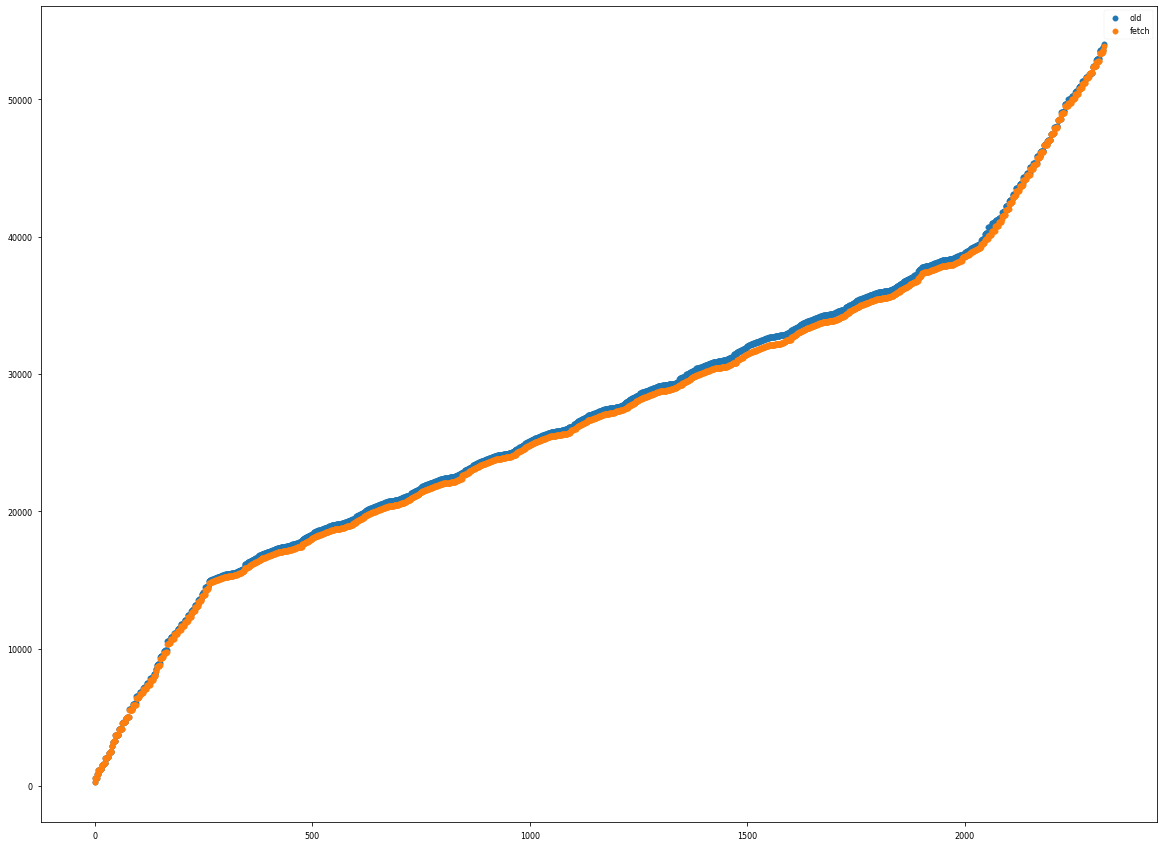

In [31]:
# temp debugging
# read old text
with open(os.path.join(HOME, 'data/decode/old2-num.txt')) as f:
    lines = f.readlines()
    old = [int(l) for l in lines]
    
# read fetch text
with open(os.path.join(HOME, 'data/decode/4way2-num.txt')) as f:
    lines = f.readlines()
    fetch = [int(l) for l in lines]
    
cycle = range(len(old))
plt.figure(figsize=(20, 15))
plt.scatter(cycle, old)
plt.scatter(cycle, fetch)
plt.legend(['old', 'fetch'])
plt.show()